# Adversarial MNIST

Using Fast Gradient Sign Method and a modified adversarial gradient descent that works for Predictive Coding networks, we create adversarial examples for a trained generative Predictive Coding network.

## Preliminaries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import torch
dtype = torch.float
device = torch.device("cpu")
device = torch.device("cuda:0") # Uncomment this to run on GPU
import NeuralNetwork as NN
import FFNetwork as FF
import Layer
import importlib
import time
from copy import deepcopy
from IPython.display import display
from ipywidgets import FloatProgress

import random

import mnist_loader
importlib.reload(mnist_loader)
importlib.reload(NN)
importlib.reload(Layer);

def DrawDigit(x):
    plt.imshow(np.reshape(x.cpu(), (28,28)), cmap='gray', interpolation='nearest')
    plt.axis('off');

## Load MNIST DATA

In [2]:
train, validate, test = mnist_loader.load_data_wrapper()
train = [torch.tensor(train[0]).float().to(device), torch.tensor(train[1]).float().to(device)]
test = [torch.tensor(test[0]).float().to(device), torch.tensor(test[1]).float().to(device)]

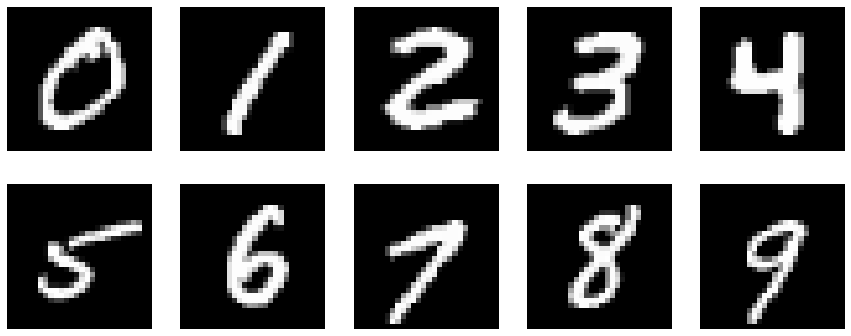

In [3]:
#      0  1   2  3   4   5   6   7   8   9
idx = [1, 3, 25, 7, 58,145, 62, 79, 41, 57]
plt.figure(figsize=[15,6])
for n,k in enumerate(idx):
    plt.subplot(2,5,n+1)
    DrawDigit(train[0][k])

## Create Network

In [4]:
importlib.reload(NN)
importlib.reload(Layer);

In [5]:
# Initialize a predictive coding neural network
net = NN.NeuralNetwork()

# Make the network structure 10-600-784
net.AddLayer(Layer.InputPELayer(n=10))
net.AddLayer(Layer.PELayer(n=600))
net.AddLayer(Layer.PELayer(n=600))
net.AddLayer(Layer.TopPELayer(n=784))

# The activation function to use, ex. 'identity', 'tanh'. 'logistic'
af = 'tanh'

# To use symmetric weights for W and M between each layer
sym = False

#Connect the layers
net.Connect(0, 1, act=af, symmetric=sym)
net.Connect(1, 2, act=af, symmetric=sym)
net.Connect(2, 3, act=af, symmetric=sym)

#Set other parameters
net.SetTau(0.2)
net.learning_tau = 0.8
net.learn_biases = False

tanh
tanh
tanh


In [ ]:
#Train this net with decay
net1 = deepcopy(net)

In [ ]:
#Train this net without decay
net0 = deepcopy(net)

## Train the Network or load pre-trained

In [ ]:
T = 5.
dt = 0.002 
epochs = 10
batch_size = 200
turn_down_lam = 1.0 
learning_delay=1.0

net1.SetWeightDecay(0.05)
net1.SetvDecay(0.0)
net1.Learn(train[1], train[0], T=T, dt=dt, epochs=epochs, batch_size=batch_size, shuffle=True, turn_down_lam=turn_down_lam, learning_delay=learning_delay)

In [6]:
net1 = NN.NeuralNetwork()
net1.Load('paper_figure10_net.npy')

# Test net1 accuracy

In [7]:
correct = 0
for i in range(0, 5):
    z = net1.BackprojectExpectation(train[0][10000*i:10000*(i+1)])
    y_classes = np.argmax(z.cpu(),1)
    t_classes = np.argmax(np.asarray(train[1][10000*i:10000*(i+1)].cpu()), 1)
    correct += np.count_nonzero((np.asarray(y_classes) - t_classes)==0)
print('with decay net train set accuracy: {rate}'.format(rate=(correct / len(train[0]))))

with decay net train set accuracy: 0.70378


In [8]:
correct = 0
z = net1.BackprojectExpectation(test[0])
y_classes = np.argmax(z.cpu(),1)
t_classes = np.argmax(np.asarray(test[1].cpu()), 1)
correct = np.count_nonzero((np.asarray(y_classes) - t_classes)==0)
print('with decay net test set accuracy: {rate}'.format(rate=(correct / len(test[0]))))

with decay net test set accuracy: 0.7141


In [9]:
#Get top two classes
correct = 0
z = net1.BackprojectExpectation(test[0]).cpu()

top_two = np.argsort(z,1)

y_classes_first = np.ndarray.flatten(top_two[:,-1:].numpy())
y_classes_second = np.ndarray.flatten(top_two[:,-2:-1].numpy())

t_classes = np.argmax(np.asarray(test[1].cpu()), 1)

correct_top = np.count_nonzero((np.asarray(y_classes_first) - t_classes)==0)
correct_second = np.count_nonzero((np.asarray(y_classes_second) - t_classes)==0)

print('with decay net test set accuracy: {rate}'.format(rate=((correct_top+correct_second) / len(test[0]))))

with decay net test set accuracy: 0.8587


# Test generative capabilities of net0 and net1

In [10]:
classes = torch.eye(10).float().to(device)

In [ ]:
net0.Allocate(classes)

net0.Reset()
net0.SetvDecay(0.0)
net0.layers[0].SetFF()
net0.layers[-1].SetFF()

z = net0.Predict(60., classes, dt=0.002)
plt.figure(figsize=[18,4])
for n,zz in enumerate(z):
    plt.subplot(2,10,n+1); DrawDigit(torch.tensor(train[0][idx[n]]))
    plt.subplot(2,10,n+11); DrawDigit(zz)

/usr/local/anaconda3/envs/ml/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  if sys.path[0] == '':


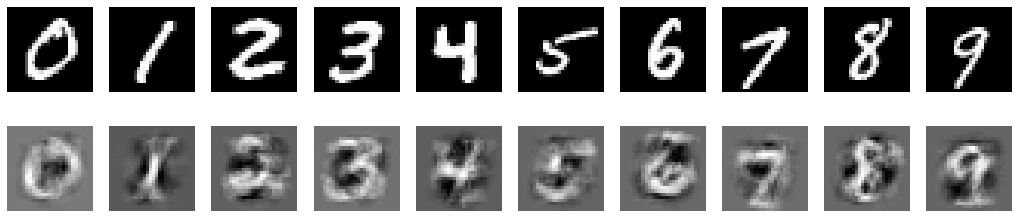

In [11]:
net1.Reset()
net1.SetvDecay(0.01)
net1.layers[0].SetFF()
net1.layers[-1].SetFF()

for layer in net1.layers:
    layer.Allocate(10)

z = net1.FastPredict(classes, T=5500, beta_time=0.2)
plt.figure(figsize=[18,4])
for n,zz in enumerate(z):
    plt.subplot(2,10,n+1); DrawDigit(torch.tensor(train[0][idx[n]]))
    plt.subplot(2,10,n+11); DrawDigit(zz)

# Save the network

In [ ]:
net1.Save('generative_net_MNIST.npy')

# Adversarial Creation

In [12]:
ffnet = FF.Network()

af = 'identity'
ffnet.AddLayer(FF.Layer(n_nodes=784, act=af))
ffnet.AddLayer(FF.Layer(n_nodes=600, act=af))
ffnet.AddLayer(FF.Layer(n_nodes=600, act=af))
ffnet.AddLayer(FF.Layer(n_nodes=10, act=af))

cost = 'cross-entropy'
ffnet.SetCostFunction(cost)

ffnet.W[0] = net1.connections[2].M
ffnet.W[1] = net1.connections[1].M
ffnet.W[2] = net1.connections[0].M

In [13]:
def PC_feedforward(net, x, af='tanh'):
    #TODO: implement adversarial gradient descent for other activation functions
    net.lyr[0].z = deepcopy(x)
    net.lyr[0].h = NN.tanh(net.lyr[0].z) #PC net transforms input state nodes through activation function

    # Loop over connections...
    for i in range (0, len(net.lyr)-1):
        net.lyr[i+1].z = net.lyr[i].h @ net.W[i]
        
        if i + 1 < len(net.lyr):
            net.lyr[i+1].h = NN.tanh(net.lyr[i+1].z)
        else:
            net.lyr[i+1].h = net.lyr[i+1].z #class layer of PC net does not apply activation function

    return net.lyr[-1].h

In [14]:
def Adversarial_Gradient_Ascent(net, image_to_perturb, actual_class, af='tanh'):
    y = PC_feedforward(net, image_to_perturb, af='tanh')

    diEdiz = -1.0 * actual_class * torch.reciprocal(y) #derivative of cross entropy loss and identity af
    for i in range(net.n_layers-2, -1, -1):
        diEdiz = diEdiz @ net.W[i].transpose(1,0) * NN.tanh_p(net.lyr[i].z)

    return diEdiz

digit 0 classified as 0 with confidence 0.15546958148479462
digit 1 classified as 1 with confidence 0.3619200885295868
digit 2 classified as 2 with confidence 0.2851071059703827
digit 3 classified as 3 with confidence 0.2991389036178589
digit 4 classified as 4 with confidence 0.3031764328479767
digit 5 classified as 5 with confidence 0.41112828254699707
digit 6 classified as 6 with confidence 0.39817968010902405
digit 7 classified as 7 with confidence 0.3408295512199402
digit 8 classified as 8 with confidence 0.2932186424732208
digit 9 classified as 9 with confidence 0.24657507240772247


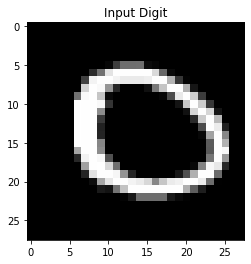

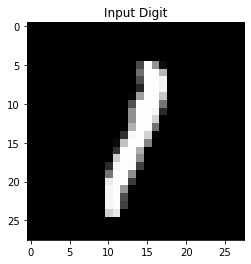

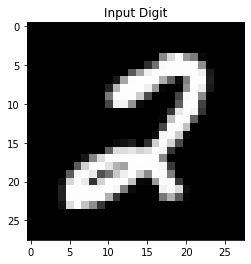

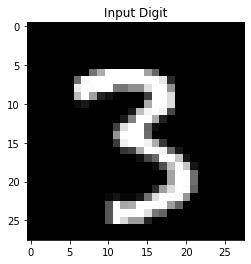

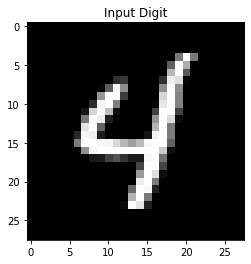

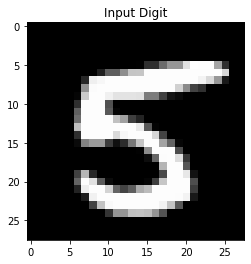

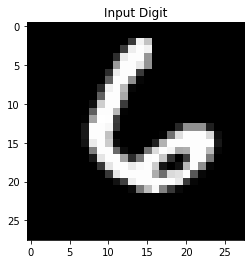

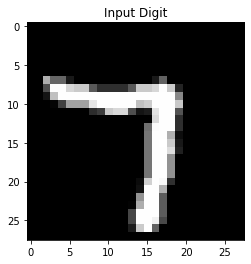

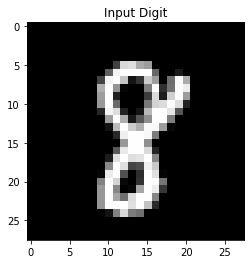

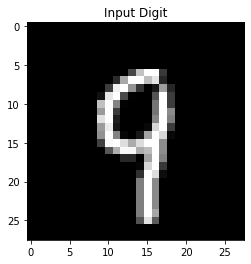

In [15]:
#Extract 10 digits from MNIST classified correctly by the PC network

net1.Allocate(1)
net1.Reset()

x_image = []
x_class = []
for i in range(0, 10):
    while True:
        j = random.randint(0, 10000)
        if np.argmax(test[1][j].cpu()) == i:
            
            net1.BackprojectExpectation(test[0][j])
            y = net1.connections[0].sigma(net1.layers[1].v)@net1.connections[0].M 
            
            if np.argmax(y.cpu()) == i:
                x_image.append(test[0][j])
                x_class.append(test[1][j])
                break

for i in range(0, len(x_image)):
    digit = np.reshape(x_image[i].cpu(), ((28, 28)))
    plt.figure()
    plt.title('Input Digit')
    plt.imshow(digit, cmap='gray')
    
    net1.BackprojectExpectation(x_image[i])
    y = net1.connections[0].sigma(net1.layers[1].v)@net1.connections[0].M 
    
    prediction = np.argmax(y.cpu())
    actual = np.argmax(x_class[i].cpu())
    
    print('digit {t_class} classified as {y_class} with confidence {conf}'.format(t_class=actual, y_class=np.argmax(y.cpu()), conf=y[prediction]))

In [16]:
#Generate some adversarial digits
num_of_adversarials = 10
j = 0

while j < num_of_adversarials:
    #Loop over the digits 0-9 the network correctly classifies, creating an adversarial version of each
    for i in range(0, 10):
        it = 0
        it_lim = 100000 #Stop perturbing after this many iterations of Adversarial_Gradient_Ascent
        
        x = deepcopy(x_image[i])
        while it < it_lim:
            #Get a perturbation vector
            perturbation = Adversarial_Gradient_Ascent(ffnet, x_image[i], x_class[i])
            
            #Purrrrrturb the image
            x += 0.1*torch.sign(perturbation)
            
            #Check the network's prediction of purrturbed image's class
            predict = PC_feedforward(ffnet, x, af='tanh')
            predicted_class = np.argmax(predict.cpu())
            
            if predicted_class != i:
                print('{actual} classified as {y_class} with confidence {conf}'.format(actual=i, y_class=predicted_class, conf=predict[predicted_class]))
                break
            elif it > it_lim:
                print('Could not force the digit {i} to be adversarially perturbed within {it_lim} iterations'.format(i=i, it_lim=it_lim))
                break
            it += 1

        np.save('adversarial_digit_{p}'.format(p=str(j+i)), x.cpu())
    j += 10

0 classified as 2 with confidence 0.17593815922737122
1 classified as 2 with confidence 0.13443145155906677
2 classified as 8 with confidence 0.1671081781387329
3 classified as 8 with confidence 0.1799861639738083
4 classified as 9 with confidence 0.1743953824043274
5 classified as 3 with confidence 0.24201303720474243
6 classified as 2 with confidence 0.24765560030937195
7 classified as 9 with confidence 0.169544979929924
8 classified as 3 with confidence 0.210488423705101
9 classified as 3 with confidence 0.15527035295963287


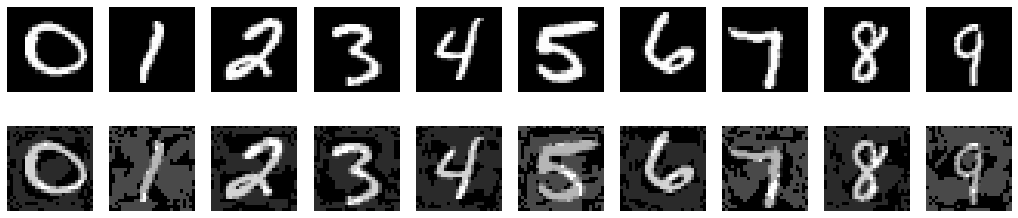

In [17]:
#Display adversarial images

adversarials = []
for j in range (0, num_of_adversarials):
    x = np.load('adversarial_digit_{j}.npy'.format(j=j))
    adversarials.append(torch.unsqueeze(torch.tensor(x).float().to(device), dim=0))

plt.figure(figsize=[18,4])
for n,zz in enumerate(adversarials):
    plt.subplot(2,10,n+1); DrawDigit(x_image[n])
    plt.subplot(2,10,n+11); DrawDigit(zz)

In [18]:
#Run the network in discriminative mode on the adversarial images
b = torch.Tensor(10, 784).float().to(device)
adversarials = torch.cat(adversarials, out=b)

net1.Reset()    
z = net1.Generate(T=10.0, y=adversarials, dt=0.001)
    
print(z)

tensor([[ 0.0939,  0.0096,  0.1714, -0.0412, -0.0278,  0.0076,  0.1461,  0.0245,
          0.0363,  0.0223],
        [ 0.0027,  0.1192,  0.1304,  0.1055,  0.0226,  0.0098,  0.0527,  0.0135,
          0.0999,  0.0022],
        [ 0.0697,  0.0532,  0.1279, -0.0281, -0.0435,  0.1057,  0.1153,  0.0836,
          0.1627,  0.0373],
        [ 0.0053,  0.0976,  0.0332,  0.0681,  0.1104,  0.0658, -0.0934,  0.0809,
          0.1755,  0.1426],
        [ 0.0204, -0.0037,  0.0771, -0.0300,  0.1618,  0.0334,  0.0826,  0.1053,
          0.0552,  0.1699],
        [ 0.0698,  0.0031,  0.0644,  0.2376,  0.1295,  0.1801, -0.0172,  0.0575,
          0.1068,  0.1263],
        [ 0.0415, -0.0844,  0.2437,  0.0276,  0.0407, -0.0126,  0.2170,  0.0414,
         -0.0025,  0.0713],
        [-0.0117, -0.0459,  0.0546,  0.1553,  0.1286,  0.0940, -0.0305,  0.0960,
          0.1115,  0.1651],
        [-0.0064,  0.1868,  0.0713,  0.2057,  0.0760,  0.0677,  0.0176,  0.0369,
          0.1721,  0.0642],
        [ 0.0098,  

In [19]:
#Print adversarial classifications
print(np.argmax(z.cpu(), axis=1))

tensor([2, 2, 8, 8, 9, 3, 2, 9, 3, 3])
